## Raw ideas


so here's a few quick ideas for a validation schema:

- data shouldn't be shuffled before training, cause it's essential to have the time series values in consecutive order
- currently I came up with three ideas for a schema:

  1. `1,2train+3valid` -> `1,2,3train+4valid` -> `1,2,3,4train+5valid` etc.

     **Advatages**:

     - the train set grows, probably helping to test model's robustness
     - we always validate on different parts of the training set

     **Disadvantages**:

     - computationally heavy. at some point our train will contain almost the entire dataset

  2. `1,2train+3valid` -> `2,3train+4valid` -> `3,4train+5valid`

     **Advantages**:

     - fixed train size, no computational power issues
     - we can somewhat efficiently use our dataset since we use each fold several times during different trainig sessions

     **Disadvantages**:

     - the fact that different sets overlap might be a problem (shouldn't be, but who knows)

  3. `1,2train+3valid` -> `4,5train+6valid` -> `7,8train+9valid`

     **Advantages**:

     - the easiest one to implement, goes through each fold once only
     - it's guaranteed that there's no overlapping or data leaks

     **Disadvantages**:

     - data hugry in some sense, each fold is used only ones and each trainig session takes $f_{train} + 1$ folds, where $f_{train}$ is the amount of folds for the trainig set. this might be a problem assuming we have only 33 folds at maximum


model ideas:

- **decision tree-based algorithms (boosting, random forest)**:

  seems to be a good choice for the task since we have a lot of categorical features and the target is a discrete variable (which is typical for decision tree regression). at the same time, trees can be overfit easily, which can cause a huge loss in robustness and very inaccurate predictions on unseen data. ensembles will help to resolve this, but the problem of overfitting won't be gone completely. also, decision trees don't work well once something completely unseen shows up in input data, which might be a problem during future usage

- **auto-regressive models**:

  a time-series specific solution, that's supposed to do a good job at predicting future sales based on historical data. the main problems are the following: 1. I don't have any experience working with them (but we'll still try I guess) 2. the data is still quite noisy, so using AR models will require some additional preprocessing

- **RNNs**:

  one of the hardest models to implement, but at the same time a really powerfull (in theory) solution, that by definition fits the task idea quite well. RNNs can be really good when it comes to analyzing consecitive data (like text processing or time series)


useful additional features:

- month
- year
- lagged values (look them up in `EDA`)
- ...


## Loading and preparing the data

the point is to load the data in a format that's actually going to be fed to the model


In [1]:
from sys import path
path.append('../')

In [2]:
from src.utils import FoldLoader, FeatureExtractor
from src.transform import ETL
from src.train_model import train_model
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import os
import xgboost
import seaborn as sns
import catboost as cb
import numpy as np
import pandas as pd
import re
from math import sin, cos, pi
from warnings import filterwarnings
filterwarnings('ignore', category=FutureWarning)

In [3]:
DATA_DIR = '../data/competitive-data-science-predict-future-sales/'

In [4]:
def etl_process():
    pipeline = ETL(DATA_DIR, ['sales_train.csv',
                   'items', 'shops', 'item_categories'])
    pipeline.extract()
    pipeline.tarnsform()
    pipeline.load(os.path.join(DATA_DIR, 'processed_files/'))

In [5]:
# uncomment if data reloading is needed (made this specifically after switching
# the working device since the data dir is not on github)
# etl_process()

In [6]:
data = pd.read_csv(os.path.join(
    DATA_DIR, 'processed_files/processed_data.csv'))
categories = pd.read_csv(os.path.join(DATA_DIR, 'item_categories.csv'))
items = pd.read_csv(os.path.join(DATA_DIR, 'items.csv'))
shops = pd.read_csv(os.path.join(DATA_DIR, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [7]:
extractor = FeatureExtractor(data, 
                             test, 
                             items, 
                             shops, 
                             categories, 
                             34)

## Feature extraction


In [8]:
in_features = ['shop_id', 'item_id']
target = 'item_cnt_day'
cat_cols = ['shop_id', 'item_id']

In [9]:
item_cats = items.merge(categories, how='inner', on='item_category_id')
lookup = {}
shop_types = ['ТЦ', 'ТРК', 'ТРЦ', 'ЧС', 'МТРЦ', 'ТК', 'Выездная']


def month_wrapper(func: callable):
    def ex_month(x):
        month = x % 12 + 1
        return func(2*pi*month/12)
    return ex_month


def fetch_cat(id):
    if id not in lookup:
        lookup[id] = item_cats[item_cats['item_id'] == id]['item_category_name'].unique()[
            0]
    return lookup[id]


def gen_cat(id):
    cat = fetch_cat(id)
    return 'Игры' if cat.startswith('Игры') \
        else re.split(r'\s*-\s*', cat)[0]


def get_shop_type(shop_name):
    for st in shop_types:
        if st in shop_name:
            return st
    return 'Other'



new_features = [
    'month_sin',
    'month_cos',
    'item_cat',
    'general_cat',
    'city',
    'shop_type'
]
sources = [
    'date_block_num',
    'date_block_num',
    'item_id',
    'item_id',
    'shop_name',
    'shop_name'
]
extractors = [
    month_wrapper(sin),
    month_wrapper(cos),
    fetch_cat,
    gen_cat,
    lambda x: x.split()[0],
    get_shop_type
]

extractor.extract_features(sources, new_features, extractors)

in_features += new_features
cat_cols += [
    'item_cat',
    'general_cat',
    'city',
    'shop_type'
]

# done

In [10]:
for lag in range(1, 5):
    extractor.add_lags('item_price', lag, ['shop_id', 'item_id'])
    extractor.add_lags('item_cnt_day', lag, ['shop_id', 'item_id'])

In [19]:
extractor.train[target] = extractor.train[target].clip(0, 30)

In [11]:
# first_time_sales = grouped[['date_block_num', 'item_id']].groupby('item_id', as_index=False).min()
# grouped = grouped.merge(first_time_sales, how='inner', on='item_id', suffixes=['init', 'fts'])
# grouped = grouped.rename(columns={'date_block_numinit':'date_block_num', 'date_block_numfts':'first_sold'})

In [12]:
# grouped['since_first_sale'] = grouped['date_block_num'] - grouped['first_sold']

## Catboost


In [13]:
extractor.features

['date_block_num',
 'shop_id',
 'item_id',
 'month_sin',
 'month_cos',
 'item_cat',
 'general_cat',
 'city',
 'shop_type',
 'item_price_lag_1',
 'item_cnt_day_lag_1',
 'item_price_lag_2',
 'item_cnt_day_lag_2',
 'item_price_lag_3',
 'item_cnt_day_lag_3',
 'item_price_lag_4',
 'item_cnt_day_lag_4']

In [20]:
model = cb.CatBoostRegressor(cat_features=cat_cols, random_seed=42)
catboost_model = train_model(model,
                             extractor.train, 
                             cat_cols, 
                             extractor.features, 
                             target, lower=0, upper=33)

Learning rate set to 0.161567
0:	learn: 2.7106223	test: 2.5086473	best: 2.5086473 (0)	total: 533ms	remaining: 8m 52s
1:	learn: 2.6054353	test: 2.4102906	best: 2.4102906 (1)	total: 1.07s	remaining: 8m 56s
2:	learn: 2.5230581	test: 2.3427733	best: 2.3427733 (2)	total: 1.56s	remaining: 8m 37s
3:	learn: 2.4630137	test: 2.2869330	best: 2.2869330 (3)	total: 2.06s	remaining: 8m 32s
4:	learn: 2.4039755	test: 2.2408932	best: 2.2408932 (4)	total: 2.53s	remaining: 8m 23s
5:	learn: 2.3401937	test: 2.2172456	best: 2.2172456 (5)	total: 2.99s	remaining: 8m 16s
6:	learn: 2.2920719	test: 2.1897800	best: 2.1897800 (6)	total: 3.47s	remaining: 8m 12s
7:	learn: 2.2575055	test: 2.1807414	best: 2.1807414 (7)	total: 3.92s	remaining: 8m 6s
8:	learn: 2.2253567	test: 2.1782535	best: 2.1782535 (8)	total: 4.23s	remaining: 7m 46s
9:	learn: 2.2012822	test: 2.1859221	best: 2.1782535 (8)	total: 4.69s	remaining: 7m 44s
10:	learn: 2.1805908	test: 2.1808794	best: 2.1782535 (8)	total: 5.33s	remaining: 7m 58s
11:	learn: 2.

In [15]:
def create_submission(model, test_df: pd.DataFrame,  in_features: list[str], filename: str, round=False):
    predicts = model.predict(test_df[in_features])
    if round:
        predicts = [int(x) for x in predicts]
    submission = pd.DataFrame(
        {'ID': range(len(predicts)), 'item_cnt_month': predicts})
    filename_ = os.path.join(DATA_DIR, filename)
    submission.to_csv(filename_, index=False)
    return predicts

In [22]:
predictions = create_submission(
    catboost_model, extractor.test, extractor.features, 'usual_subm.csv', True)

In [25]:
loader = FoldLoader(extractor.train, 8, n_valid_folds=2, folding_mode='seq')

In [27]:
template = 'fold: [{:2} out of {:2}]\tRMSE-train: [{:3.3f}]\tRMSE-val: [{:3.3f}]'
index = 1
history = {'loss': [], 'score': []}
loader.reset_folds()
model = cb.CatBoostRegressor(cat_features=cat_cols, random_seed=42)
for train, val in tqdm(loader):
    # fetch data
    train_data = cb.Pool(train[extractor.features],
                         train[target], cat_features=cat_cols)
    val_data = cb.Pool(val[extractor.features], val[target], cat_features=cat_cols)
    # reset the model
    model.fit(train_data, eval_set=val_data, use_best_model=True,
              verbose=False, early_stopping_rounds=50)

    # validate
    preds = model.predict(train[extractor.features])
    rmse_train = (np.sqrt(mean_squared_error(train[target], preds)))
    preds = model.predict(val[extractor.features])
    rmse_val = (np.sqrt(mean_squared_error(val[target], preds)))
    print(template.format(index, len(loader), rmse_train, rmse_val))
    index += 1

  0%|          | 0/3 [00:00<?, ?it/s]

fold: [ 1 out of  3]	RMSE-train: [1.999]	RMSE-val: [2.729]
fold: [ 2 out of  3]	RMSE-train: [2.148]	RMSE-val: [2.006]
fold: [ 3 out of  3]	RMSE-train: [2.086]	RMSE-val: [1.955]


In [31]:
preds = create_submission(model, extractor.test, extractor.features,
                  'stack_trained_subm.csv', round=False)

### CatBoost conclusion

So, the results are explainable, scores on validation and testing are approx. the same
The scores themselves aren't that good and I'm not sure what I can do about it.
Currently it seems like no matter what I do, the model starts overfitting after
reaching the score of approx `2.65`, which doesn't seem that good

Right now the plan is to try different types of model and see if they will have
any similar issues

currenty the score situation is as follows:

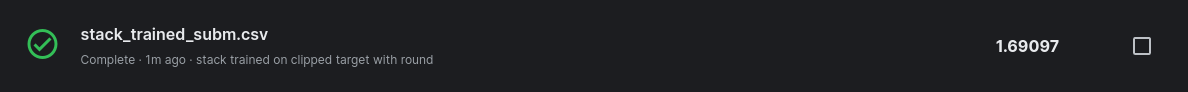

basing on those results it seems like it's better to train the model on more recent data, which makes it adapt to
the trend better (also idk if it's fair to round the predictions, but it does increase the score by a fair amount)

## XGBoost


## RandomForest

this one requires manually encoding some features, since it can't process categorical features out-of-the-box. again, planning to see the scores I get and compare to others


## RNN

requires encoding cat. features too.
